## Distance of trans-eQTLs from the human TFs

 - How far are the trans-eQTLs from known transcription factors?
 - How does it compare to some randomly selected SNPs from the data?

In [46]:
resdir = "/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v6_gtknn/"
tissuelist = ["ms", "at", "thy", "nt", "snse", "lu", "av", "br", "hlv", "aa", "haa", "colt", "as", "sse"]
tissuelist = ["gtex-ms", "gtex-as", "gtex-sse"]
tissue_file = "../plots/tissues.txt"
tejaas_preproc = "raw"
tejaas_method_variant = "permnull_sb0.1_knn30"
rrfile = "rr.txt"
chrmlist = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
tffile = "../TF_annotation.txt"
Nrand = 50000
cis_window = 0.1 # (in Mb)
pcutoff = 5e-8

snpdir = '/cbscratch/franco/datasets/gtex_v8/genotypes/'
gtfile_fmt = 'GTEX_v8_2019-07-29_WGS_838Indiv_Freeze_NoMissingGT_SNPfilter_MAF0.01_withDS_chr{:d}.snplist'
json_file = "../gtex_metadata.json"

In [17]:
import numpy as np
import collections
import os
import time
import math
import json

import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib
import sys
sys.path.append('../')
from utils import utils
from utils import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 22, colors = 'banskt', dpi = 300)

log10cutoff = -np.log10(pcutoff)

In [18]:
GENEINFO_FIELDS = ['name', 'ensembl_id', 'chrom', 'start', 'end']
class GeneInfo(collections.namedtuple('_GeneInfo', GENEINFO_FIELDS)):
    __slots__ = ()

tflist = list()
with open(tffile, 'r') as instream:
    next(instream)
    for line in instream:
        linesplit = line.strip().split()
        ensembl = linesplit[0]
        chrom = int(linesplit[1])
        start = int(linesplit[2])
        end = int(linesplit[3])
        name = linesplit[4]
        tflist.append(GeneInfo(name = name, ensembl_id = ensembl, chrom = chrom, start = start, end = end))

In [47]:
tshorts, tfulls = utils.read_tissues(tissue_file)
tshorts = ["gtex-"+t for t in tshorts]
with open(json_file) as instream:
    gtex_meta = json.load(instream)
tissue_colors = dict()
tissue_names = dict()
for tshort, tfull in zip(tshorts, tfulls):
    if tshort in tissuelist:
        tissue_names[tshort] = tfull
        tissue_colors[tshort] = "#" + gtex_meta[tfull.replace(" ", "_")]["colorHex"]

In [20]:
def find_minimum_distance(spos, starts, ends):
    diffs = zip([spos - x for x in starts], [spos - x for x in ends])
    dists = np.array([math.copysign(min(abs(a), abs(b)), a) if a * b > 0 else 0 for a, b in diffs])
    return dists[np.argmin(np.abs(dists))]

def find_minimum_distance_from_start(spos, starts):
    dists = np.array([spos - x for x in starts])
    return dists[np.argmin(np.abs(dists))]

In [33]:
def read_tejaas(filename, chrm):
    rsidlist = list()
    bplist   = list()
    pvallist = list()
    with open(filename, 'r') as instream:
        next(instream)
        for line in instream:
            linesplit = line.strip().split()
            rsid = linesplit[0]
            bppos = int(linesplit[1])
            rsid = f'chr{chrm}_{bppos}_gtex'
            pval = float(linesplit[5])
            rsidlist.append(rsid)
            bplist.append(bppos)
            pvallist.append(pval)
    return rsidlist, pvallist, bplist

def read_tejaas_all_chrom(filefmt, chrmlist):
    gwrsids = list()
    gwpvals = list()
    gwnsnps = dict()
    gwbppos = dict()
    
    for chrm in chrmlist:
        filepath = filefmt.format(chrm)
        rsids, pvals, bplist = read_tejaas(filepath, chrm)
        gwrsids += rsids
        gwpvals += pvals
        gwnsnps[chrm] = len(rsids)
        gwbppos[chrm] = np.array(bplist)
        
    gwpvals = np.array(gwpvals)
    
    ## Sanity check of p-value
    # Are there any nan p-values?
    nan_mask = np.isnan(gwpvals)
    if np.any(nan_mask):
        print(f'SNPs with nan p-value: {np.sum(nan_mask)}')
        gwpvals[np.where(nan_mask)[0]] = 1.0 ## just ignore this SNP
        
    # Are there any zero p-values
    zero_mask = gwpvals == 0
    if np.any(zero_mask):
        print(f'SNPs with zero p-value: {np.sum(zero_mask)}')
        gwpvals[np.where(zero_mask)[0]] = np.min(gwpvals[~zero_mask])    
    
    #pmax  = np.max(gwpvals[np.where(gwpvals > 0)])
    #nonzero_pvals = gwpvals.copy()
    #nonzero_pvals[np.where(gwpvals == 0)] = pmax
    
    return gwrsids, gwnsnps, gwbppos, gwpvals

#### Randomly selected SNPs

Select `Nrand` random SNPs, and find the distance of their nearest transcription factors. The distribution of these distances `mindist_rand` would serve as a background.

To check enrichment, we select 1000 SNPs and check the distance enrichment multiple times. 

In [22]:
snppos = dict()
for chrm in chrmlist:
    fname = os.path.join(snpdir, gtfile_fmt.format(chrm))
    with open (fname, 'r') as instream:
        first = next(instream).strip().split()[0]
        for line in instream:
            pass
        last = line.strip().split()[0]
    firstpos = int(first.split('_')[1])
    lastpos = int(last.split('_')[1])
    snppos[chrm] = list([firstpos, lastpos])

In [23]:
def random_mindist(Nrand, snppos, chrmlist):
    mindist_rand = list()
    ratios = np.random.rand(len(chrmlist))
    ndraws = [int(x) for x in np.around(Nrand * ratios / np.sum(ratios))]
    for i, chrm in enumerate(chrmlist):
        N = ndraws[i]
        firstpos = snppos[chrm][0]
        lastpos  = snppos[chrm][1]
        rands = firstpos + np.random.rand(N) * (lastpos - firstpos)
        selects = np.sort([int(x) for x in rands])
        tfchrmlist = [x for x in tflist if x.chrom == chrm]
        tfstarts = [x.start for x in tflist if x.chrom == chrm]
        tfends = [x.end for x in tflist if x.chrom == chrm]
        for spos in selects:
            xmin = find_minimum_distance(spos, tfstarts, tfends)
            mindist_rand.append(xmin / 1e6)
    mindist_rand = np.array(mindist_rand)
    return mindist_rand

In [24]:
Niter = 10
tf_frac_rand = 0
for i in range(Niter):
    mindist_rand = random_mindist(Nrand, snppos, chrmlist)
    this_tf_frac = np.sum(np.abs(mindist_rand) <= cis_window) / mindist_rand.shape[0]
    print(f'Iteration {i}. Fraction of SNPs with cis TFs = {this_tf_frac}')
    tf_frac_rand += this_tf_frac
tf_frac_rand /= Niter

print(f'Fraction of cis TFs for randomly selected SNPs: {tf_frac_rand :7.4f}')

Iteration 0. Fraction of SNPs with cis TFs = 0.13286
Iteration 1. Fraction of SNPs with cis TFs = 0.12315753684926302
Iteration 2. Fraction of SNPs with cis TFs = 0.12474498979959199
Iteration 3. Fraction of SNPs with cis TFs = 0.13478
Iteration 4. Fraction of SNPs with cis TFs = 0.12286245724914498
Iteration 5. Fraction of SNPs with cis TFs = 0.1128622572451449
Iteration 6. Fraction of SNPs with cis TFs = 0.12098241964839297
Iteration 7. Fraction of SNPs with cis TFs = 0.11710234204684093
Iteration 8. Fraction of SNPs with cis TFs = 0.14109717805643887
Iteration 9. Fraction of SNPs with cis TFs = 0.13450269005380108
Fraction of cis TFs for randomly selected SNPs:  0.1265


In [25]:
Niter = 1000
Ncheck = 1000

enrichment_rand = list()
for i in range(Niter):
    if i % 100 == 0:
        print(f'Iteration {i}')
    tfdist_rand = random_mindist(Ncheck, snppos, chrmlist)
    this_tf_frac = np.where(np.abs(tfdist_rand) < cis_window)[0].shape[0] / Ncheck
    this_tf_enrichment = this_tf_frac / tf_frac_rand
    enrichment_rand.append(this_tf_enrichment)
    
enrichment_rand = np.array(enrichment_rand)

Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900


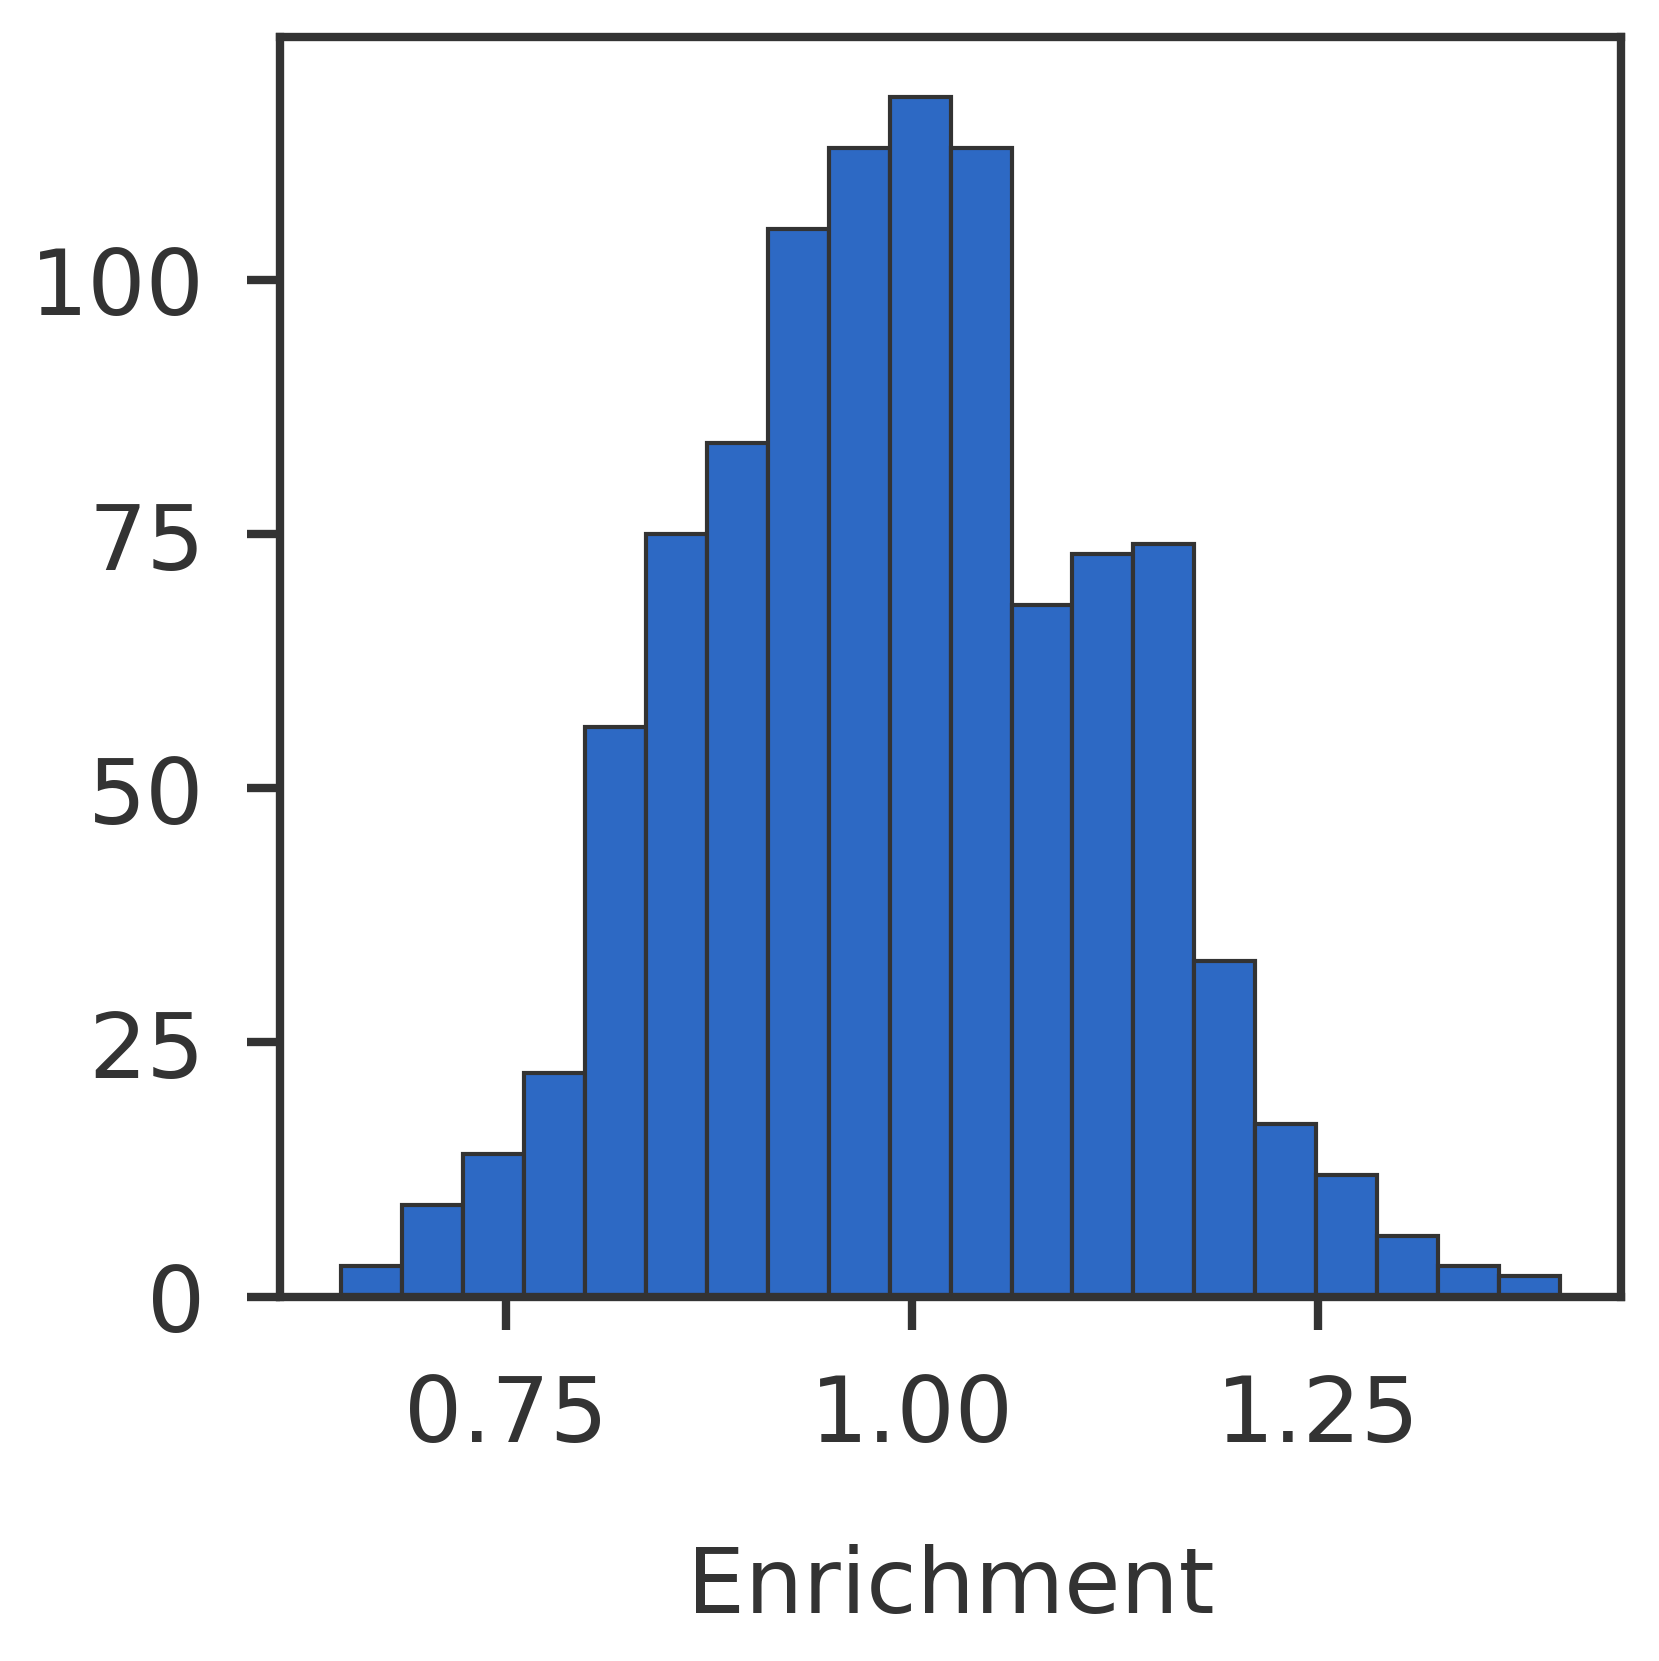

In [26]:
fig = plt.figure(figsize = (6, 6))
ax1 = fig.add_subplot(111)

ax1.hist(enrichment_rand)
ax1.set_xlabel('Enrichment')
plt.tight_layout()
plt.show()

#### Trans-eQTLs discovered by TEJAAS

In [37]:
transeqtls = dict()
        
for tissue in tissuelist:
    filefmt = f'{resdir}/{tejaas_preproc}/{tissue}/tejaas/{tejaas_method_variant}/chr' + "{:d}" + f'/{rrfile}'
    gwrsids, gwnsnps, gwbppos, gwpvals = read_tejaas_all_chrom(filefmt, chrmlist)   
    gwlog10pvals = -np.log10(gwpvals)
    nchoose = np.where(gwlog10pvals >= log10cutoff)[0]
    transeqtls[tissue] = [gwrsids[i] for i in nchoose]
    print(f'{tissue}: {len(transeqtls[tissue])} trans-eQTLs')

gtex-ms: 34 trans-eQTLs
gtex-as: 1784 trans-eQTLs
gtex-sse: 1147 trans-eQTLs


#### Add the eQTLgen results

In [48]:
eqtlgen_resfile = '/cbscratch/franco/datasets/EQTLgen/eqtlgen_signif_SNPs_uniq_rsid_chr_pos.txt'

if not 'eqtlgen' in tshorts:
    tshorts += ['eqtlgen']
    tfulls += ['EQTLGen']
    transeqtls['eqtlgen'] = list()
    tissuelist += ['eqtlgen']

    with open(eqtlgen_resfile, 'r') as infile:
        for line in infile:
            linesplit = line.strip().split()
            chrm = int(linesplit[1].strip())
            pos = linesplit[2].strip()
            var_id = f'chr{chrm}_{pos}_eqtlgen'
            if chrm in chrmlist:
                transeqtls['eqtlgen'].append(var_id)
    tissue_names['eqtlgen'] = 'EQTLGen'
    tissue_colors['eqtlgen'] = 'gray'

In [49]:
mindist = dict()

for tissue in tissuelist:
    mindist[tissue] = list()
    for teqtl in transeqtls[tissue]:
        chrm = int(teqtl.split('_')[0][3:])
        spos = int(teqtl.split('_')[1])
        firstpos = snppos[chrm][0]
        lastpos  = snppos[chrm][1]
        tfchrmlist = [x for x in tflist if x.chrom == chrm]
        tfstarts = [x.start for x in tflist if x.chrom == chrm]
        tfends = [x.end for x in tflist if x.chrom == chrm]
        xmin = find_minimum_distance(spos, tfstarts, tfends)
        mindist[tissue].append(xmin / 1e6)

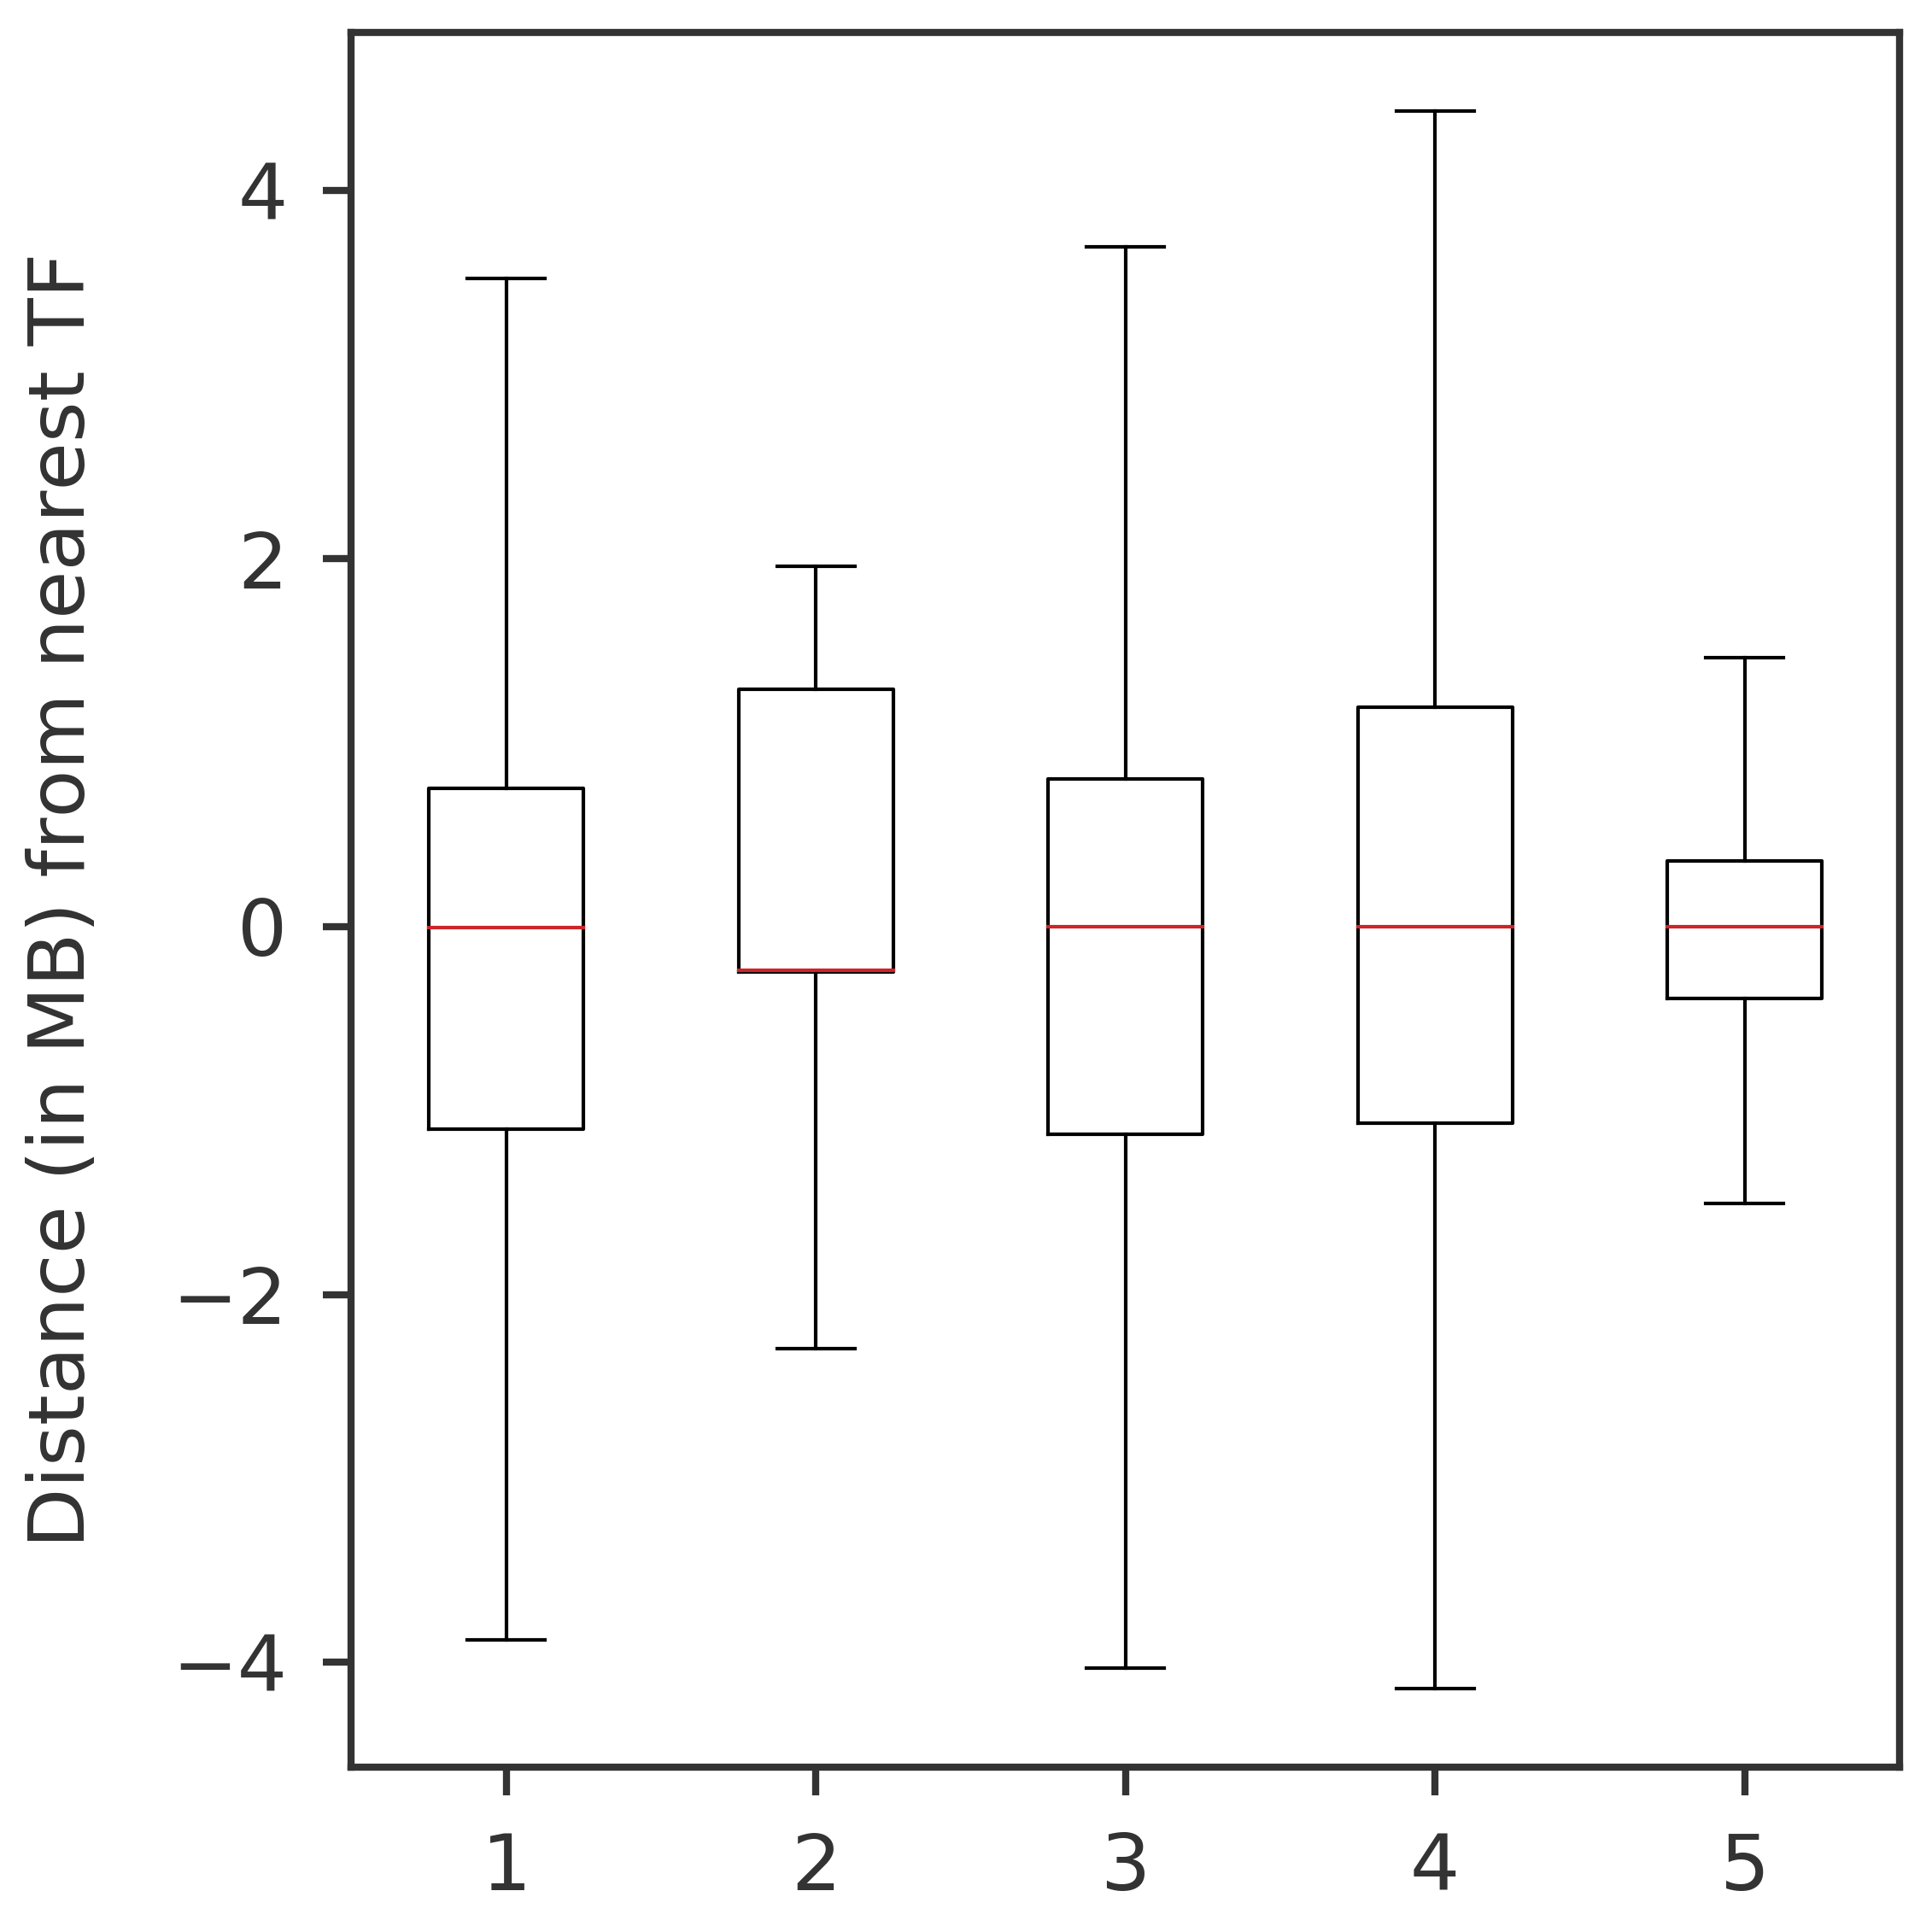

In [50]:
fig = plt.figure(figsize = (8, 8))
ax1 = fig.add_subplot(111)

data = list()
data.append(mindist_rand)
for tissue in tissuelist:
    data.append(mindist[tissue])

ax1.boxplot(data, showfliers=False)
#ax1.set_xticklabels(['Random', 'Adipose', 'Skin'])

ax1.set_ylabel('Distance (in MB) from nearest TF')
plt.tight_layout()
plt.show()

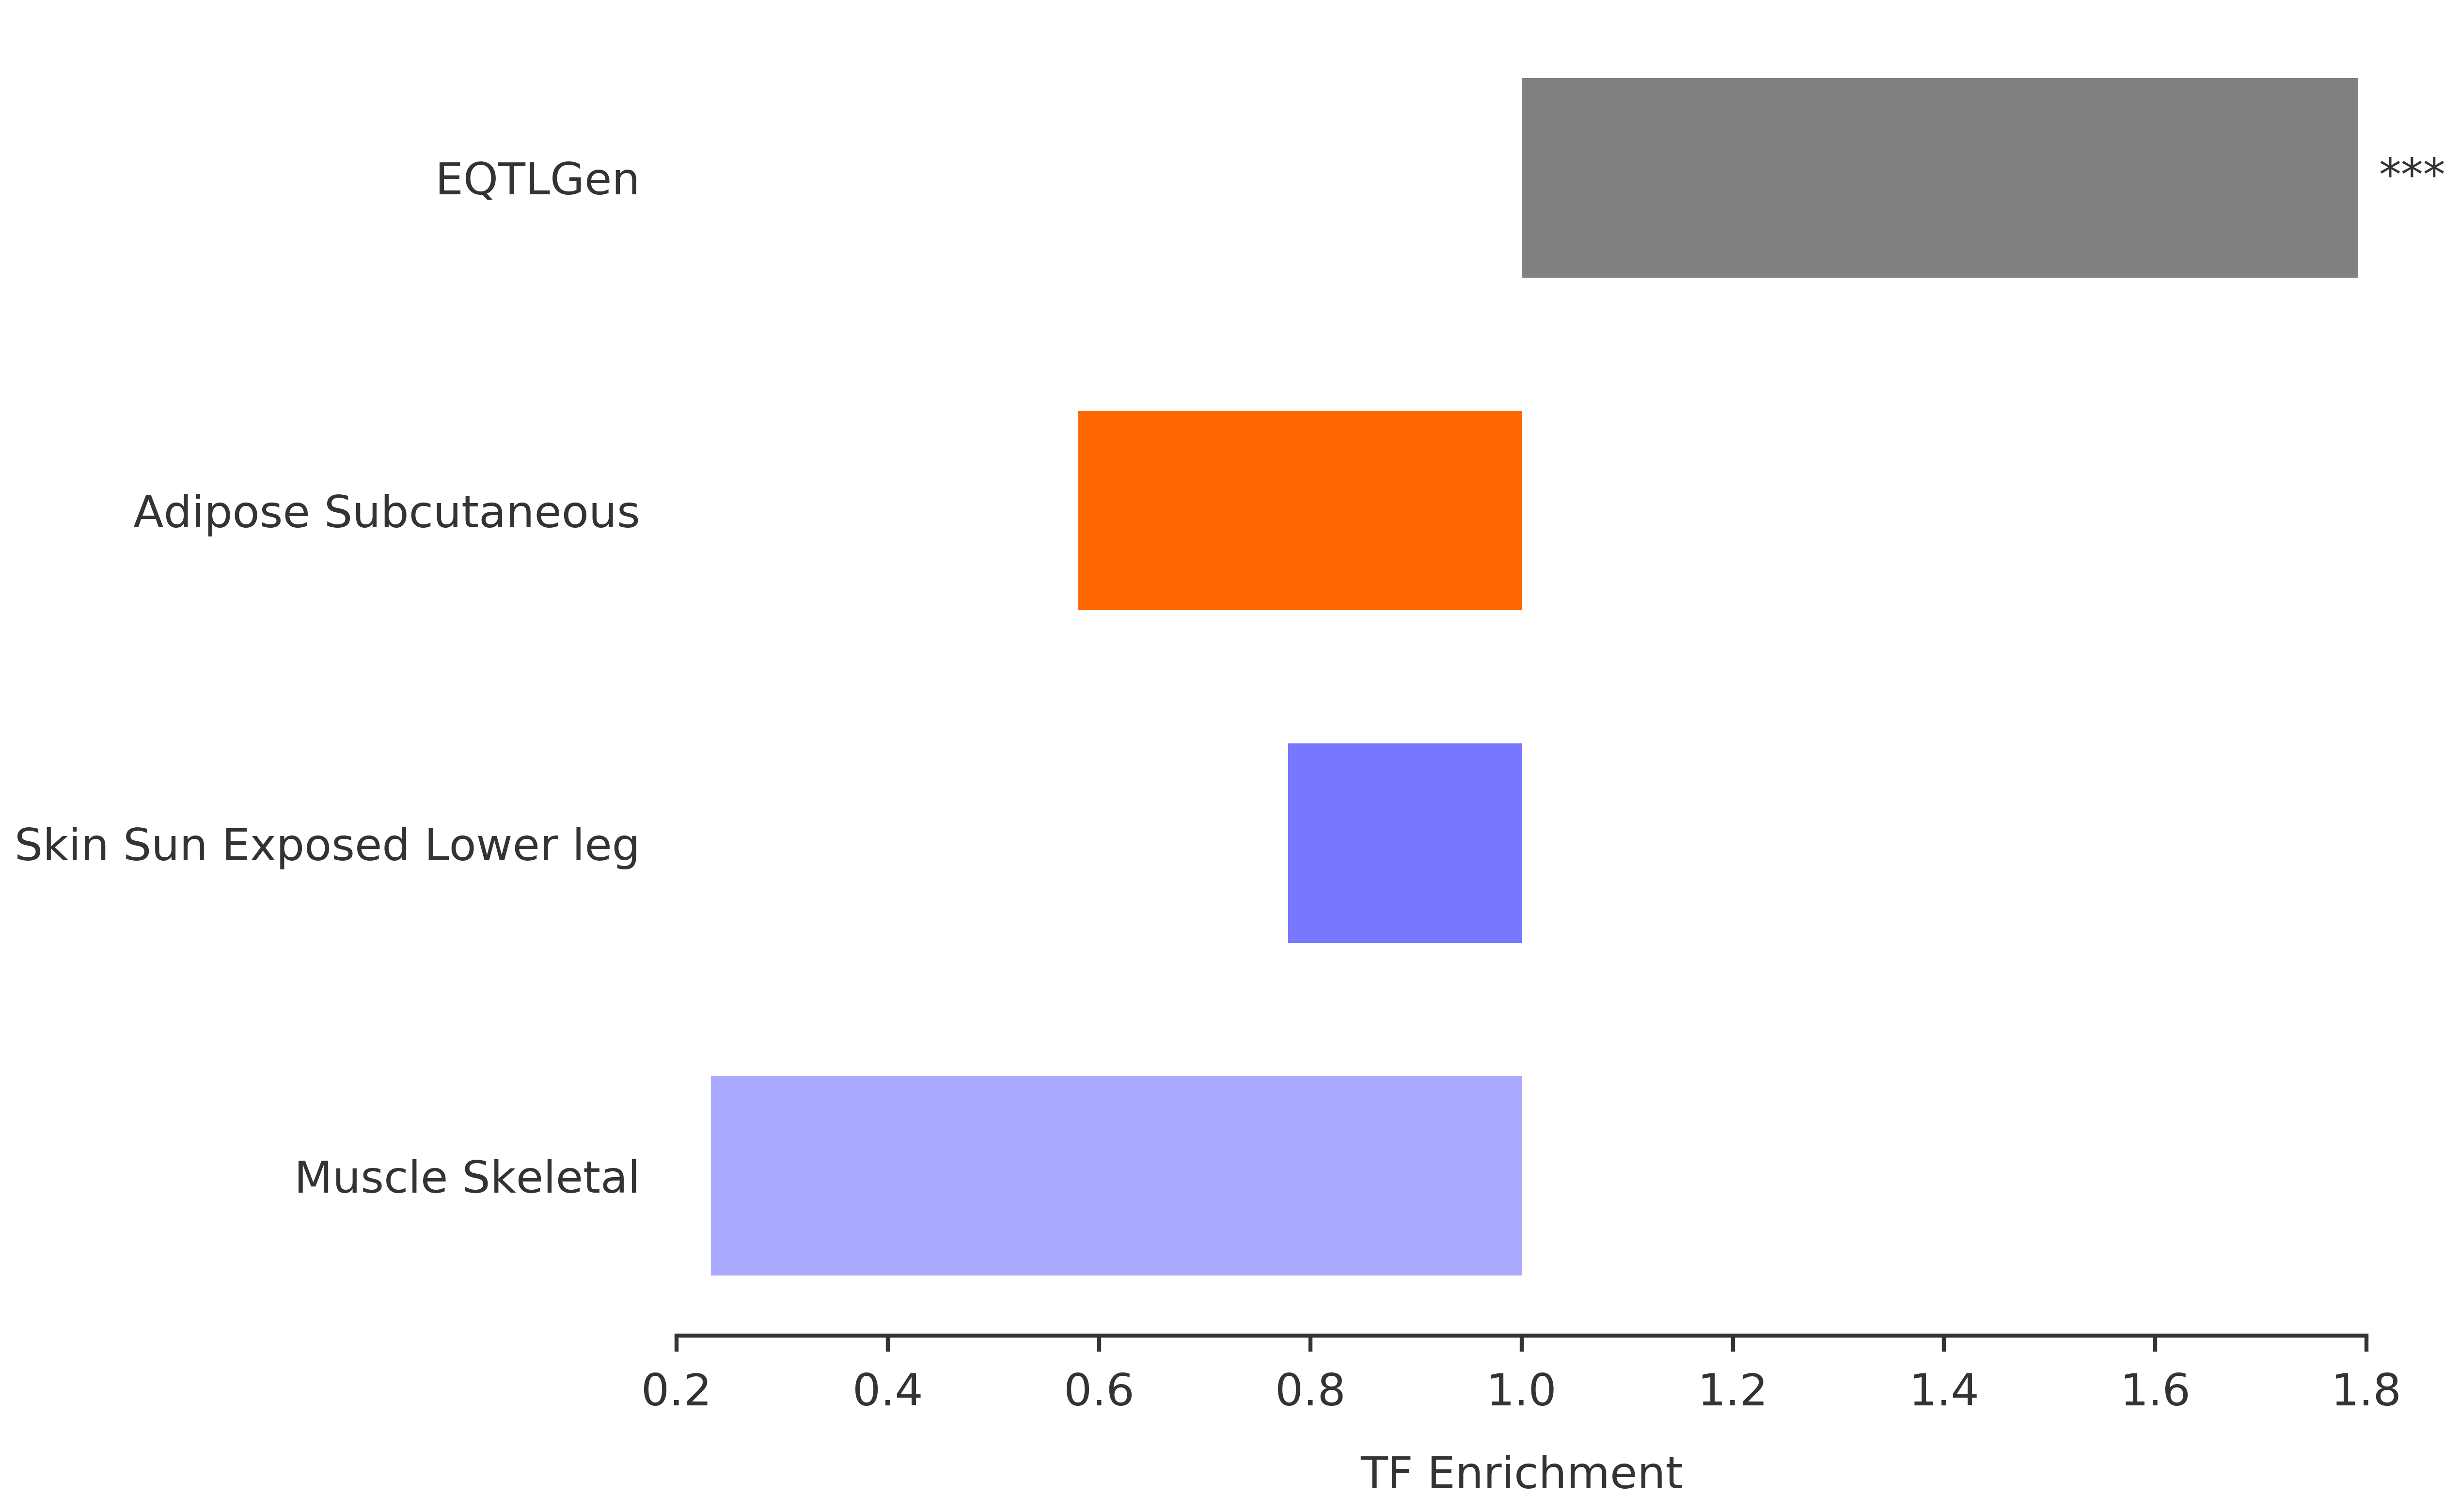

In [51]:
objects = list()
performance = list()
significance = list()
bar_colors = list()

for tshort in tshorts:
    if tshort in tissuelist:
        nteqtl = len(transeqtls[tshort])
        if nteqtl > 0:
            tf_frac_tissue = len([x for x in mindist[tshort] if abs(x) <= cis_window]) / nteqtl
            tf_enrichment = tf_frac_tissue / tf_frac_rand
            tf_enrichment_pval = (np.sum(enrichment_rand >= tf_enrichment) + 1) / (enrichment_rand.shape[0] + 1)
            
            objects.append(tissue_names[tshort])
            performance.append(tf_enrichment - 1.0)
            if tf_enrichment_pval <= 0.001:
                significance.append('***')
            elif tf_enrichment_pval <= 0.01:
                significance.append('**')
            elif tf_enrichment_pval <= 0.05:
                significance.append('*')
            else:
                significance.append('')
            bar_colors.append(tissue_colors[tshort])

        

fig = plt.figure(figsize = (15, 12))
ax1 = fig.add_subplot(111)

y_pos = np.arange(len(objects))
bar1 = ax1.barh(y_pos, performance, align='center', color = bar_colors, linewidth = 0, height = 0.6)

ax1.set_yticks(y_pos)
ax1.set_yticklabels(objects)
ax1.set_xlabel('TF Enrichment')
xmax = np.around(np.max(performance) + 0.05, decimals = 1)
xmin = np.around(np.min(performance) - 0.05, decimals = 1)
ax1.set_xlim([xmin, xmax])

ax1.tick_params(bottom = True, top = False, left = False, right = False, labelleft = True, labelbottom = True)
for side, border in ax1.spines.items():
    if not side == 'bottom':
        border.set_visible(False)
        
# Add p-values beside the bars
for i, rect in enumerate(bar1):
    width = rect.get_width()
    xpos = rect.get_width() + 0.02
    ypos = rect.get_y() + rect.get_height() / 2.0
    ax1.text(xpos, ypos, f'{significance[i]}', ha='left', va='center')

fig.canvas.draw()
xticklabels = [f'{x.get_position()[0] + 1 :3.1f}' for x in ax1.get_xticklabels()]
ax1.set_xticklabels(xticklabels)

# outfile = "../plots/tf_enrichment_100kb.png"
# plt.savefig(outfile, bbox_inches='tight')
plt.show()

In [43]:
objects
performance
# significance = list()
# bar_colors = list()

[]

In [ ]:
from scipy.interpolate import interp1d

fig = plt.figure(figsize = (12, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

xmax = np.around(np.max(mindist_rand))
xmin = np.around(np.min(mindist_rand))
bins = np.linspace(xmin, xmax, 50)
xbin = [(bins[i] + bins[i+1]) / 2 for i in range(bins.shape[0] - 1)] # centers of the bins
x = np.linspace(xbin[0], xbin[-1], 500)
yfreq, _ = np.histogram(mindist_rand, bins = bins, density = True)
#yfreq = yhist / len(mindist)
fy = interp1d(xbin, yfreq, kind = 'cubic')
y = fy(x)
ax1.plot(x, y, alpha = 1)
ax2.plot(x, y, alpha = 1)


#ax1.hist(mindist_rand, bins = 100, density = True, alpha = 0.5)
ax1.hist(mindist[tissuelist[0]], bins = 50, density = True, alpha = 0.5)
ax1.set_title(tissuelist[0])

#ax2.hist(mindist_rand, bins = 100, density = True, alpha = 0.5)
ax2.hist(mindist[tissuelist[2]], bins = 50, density = True, alpha = 0.5)
ax2.set_title(tissuelist[2])

plt.tight_layout()
plt.show()